In [1]:
%pip install -U tiktoken sentence_transformers hf_xet xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.0
    Uninstalling xgboost-3.0.0:
      Successfully uninstalled xgboost-3.0.0

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration pour les plots (optionnel, mais sympa)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Taille par défaut des figures

In [2]:
# FILE_PATH = "TMDB_movie_dataset_v11.csv"
FILE_PATH = 'TMDB_cleaned_data.csv' # Utilisation du nom générique vu dans l'EDA.md

print(f"Chargement des données depuis: {FILE_PATH}")
try:
    df_brut = pd.read_csv(FILE_PATH)
    print("Chargement réussi.")
    print("Aperçu des données:")
    display(df_brut.head(3))
    print(f"Shape initiale: {df_brut.shape}")
except FileNotFoundError:
    print(f"Erreur: Le fichier {FILE_PATH} n'a pas été trouvé. Vérifiez le chemin.")
    # Stopper l'exécution ou gérer l'erreur autrement si nécessaire
    df_brut = pd.DataFrame() # Créer un dataframe vide pour éviter les erreurs suivantes

Chargement des données depuis: TMDB_cleaned_data.csv
Chargement réussi.
Aperçu des données:


,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,homepage,...,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_year,release_month,log_revenue,genre_list
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,https://www.warnerbros.com/movies/inception,...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",2010,7,20.531540,"['Action', 'Science Fiction', 'Adventure']"
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,http://www.interstellarmovie.net/,...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",2014,11,20.369058,"['Adventure', 'Drama', 'Science Fiction']"
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,https://www.warnerbros.com/movies/dark-knight/,...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",2008,7,20.727814,"['Drama', 'Action', 'Crime', 'Thriller']"


Shape initiale: (14853, 24)


/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- preparing text for embedding and counting tokens (notebook version) ---
tiktoken loaded with 'cl100k_base' encoding.
calculating token counts...


100%|██████████| 14853/14853 [00:00<00:00, 32230.49it/s]


--- example of combined text and token counts ---


,title,text_to_embed,token_count
0,Inception,Inception Your mind is the scene of the crime....,65
1,Interstellar,Interstellar Mankind was born on Earth. It was...,54
2,The Dark Knight,The Dark Knight Welcome to a world without rul...,84
3,Avatar,Avatar Enter the world of Pandora. In the 22nd...,43
4,The Avengers,The Avengers Some assembly required. When an u...,66



--- token count statistics ---
total entries: 14853
total tokens: 1,071,500
avg tokens/entry: 72.14
median tokens/entry: 65
min tokens/entry: 2
max tokens/entry: 345

plotting distribution of token counts...


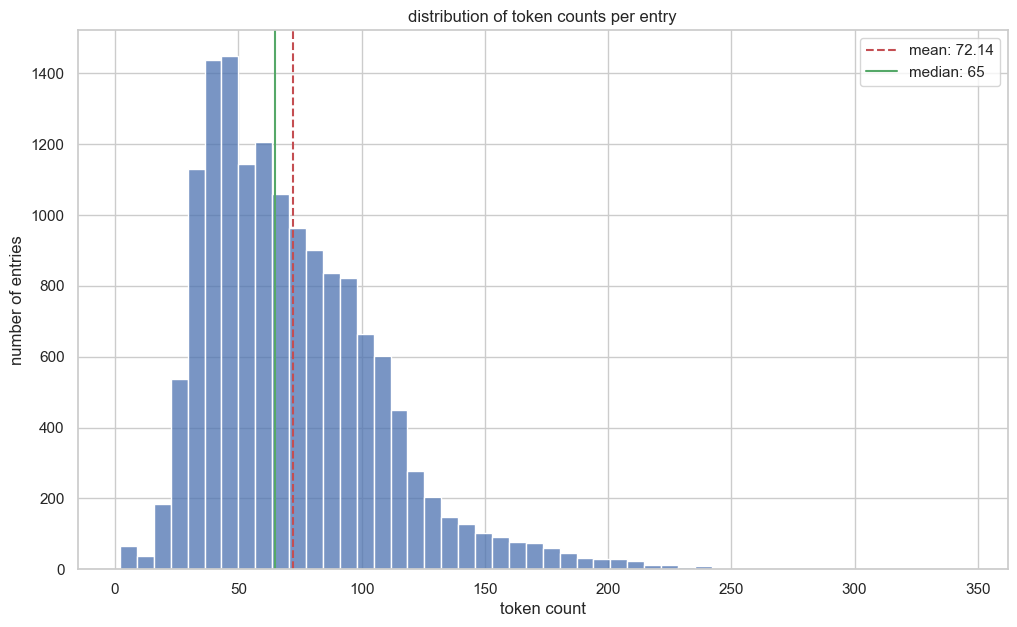

In [3]:
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns # if not already imported in a previous cell
from tqdm.auto import tqdm

# Assuming df_brut is loaded and ready from a previous cell
# And sns.set_theme, plt.rcParams are set if you want them globally

tqdm.pandas()

print("\n--- preparing text for embedding and counting tokens (notebook version) ---")

# 1. Initialize tiktoken encoder
try:
    enc = tiktoken.get_encoding("cl100k_base")
    print("tiktoken loaded with 'cl100k_base' encoding.")
except ImportError:
    print("tiktoken isn't installed. run: !pip install tiktoken")
    print("can't count tokens. proceeding without token counts.")
    enc = None
except Exception as e: # other potential tiktoken issues
    print(f"hmm, trouble getting tiktoken encoding: {e}")
    enc = None

# 2. Define columns and create 'text_to_embed'
text_cols = ['title', 'tagline', 'overview']

# fill NaNs and combine
for col in text_cols:
    if col in df_brut.columns:
        df_brut[col] = df_brut[col].fillna('')
    else:
        print(f"warn: column '{col}' not found, it will be effectively empty in 'text_to_embed'.")
        # Add an empty series if a column is missing to prevent error in the next step
        df_brut[col] = '' 

df_brut['text_to_embed'] = df_brut['title'] + " " + df_brut['tagline'] + " " + df_brut['overview']
df_brut['text_to_embed'] = df_brut['text_to_embed'].str.replace(r'\s+', ' ', regex=True).str.strip()

if enc:
    # 3. Calculate token count
    print("calculating token counts...")
    df_brut['token_count'] = df_brut['text_to_embed'].progress_apply(lambda x: len(enc.encode(x)))

    # 4. Show examples
    print("\n--- example of combined text and token counts ---")
    display(df_brut[['title', 'text_to_embed', 'token_count']].head()) # Simplified display

    # 5. Summarize token usage
    print("\n--- token count statistics ---")
    total_tokens = df_brut['token_count'].sum()
    mean_tokens = df_brut['token_count'].mean()
    median_tokens = df_brut['token_count'].median()
    min_tokens = df_brut['token_count'].min()
    max_tokens = df_brut['token_count'].max()
    
    print(f"total entries: {len(df_brut)}")
    print(f"total tokens: {total_tokens:,}")
    print(f"avg tokens/entry: {mean_tokens:.2f}")
    print(f"median tokens/entry: {median_tokens:.0f}")
    print(f"min tokens/entry: {min_tokens}")
    print(f"max tokens/entry: {max_tokens}")

    # 6. Plot distribution
    print("\nplotting distribution of token counts...")
    plt.figure() 
    sns.histplot(df_brut['token_count'], bins=50, kde=False)
    plt.title('distribution of token counts per entry')
    plt.xlabel('token count')
    plt.ylabel('number of entries')
    plt.axvline(mean_tokens, color='r', linestyle='--', label=f'mean: {mean_tokens:.2f}')
    plt.axvline(median_tokens, color='g', linestyle='-', label=f'median: {median_tokens:.0f}')
    plt.legend()
    plt.show()
    
else:
    print("\ncouldn't count tokens. 'text_to_embed' column has been created though.")
    print("\nhere's a sample of the 'text_to_embed' column:")
    display(df_brut[['title', 'text_to_embed']].head())

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np # just in case, though ST usually returns numpy arrays
import pandas as pd # for display, assuming df_brut is still our guy

print(f"found df_brut with {len(df_brut)} entries and 'text_to_embed' column.")

# 1. Load the Sentence Transformer model
# This model produces 384-dimensional embeddings.
model_name = 'all-MiniLM-L6-v2'
print(f"\nloading sentence transformer model: {model_name}...")

model = SentenceTransformer(model_name)
print("model loaded successfully.")

found df_brut with 14853 entries and 'text_to_embed' column.

loading sentence transformer model: all-MiniLM-L6-v2...
model loaded successfully.


In [5]:
# 2. Get the texts to embed
texts_to_embed = df_brut['text_to_embed'].tolist()
print(f"prepared {len(texts_to_embed)} texts for embedding.")

# 3. Encode the texts in batches
# The .encode() method handles batching internally.
# You can specify batch_size. Default is 32.
# For 15k sentences, a larger batch size like 64, 128, or 256 might be a bit faster if you have decent RAM/GPU.
# Let's use a reasonable default and show progress.
batch_size = 64 # Good starting point, adjust based on your hardware
print(f"\nstarting embedding process with batch_size={batch_size}...")
print("this will take a bit. go grab a coffee or ponder the universe.")
        
sentence_embeddings = model.encode(
    texts_to_embed,
    batch_size=batch_size,
    show_progress_bar=True, # Nice progress bar in notebooks
    convert_to_numpy=True   # Ensure output is a NumPy array
)

print("\nembedding generation complete.")
print(f"shape of embeddings: {sentence_embeddings.shape}") # Should be (num_sentences, 384)

# 4. Add embeddings to the DataFrame
# Pandas can store lists or numpy arrays in cells. Storing as a list of lists or list of arrays is common.
# Let's store them as a list of lists to be more universally friendly,
# though a column of 1D numpy arrays also works.
df_brut['embeddings'] = [emb.tolist() for emb in sentence_embeddings]
# Alternatively, for potentially better memory with Arrow etc. if your pandas version is new:
# df_brut['embeddings'] = list(sentence_embeddings) 

print("\n--- dataframe with embeddings (first few rows) ---")
# Displaying a slice that makes sense.
# The embedding column will be very wide if printed fully.
display(df_brut[['title', 'text_to_embed', 'embeddings']].head(3))

print("\n--- checking an individual embedding ---")
if len(df_brut) > 0 and 'embeddings' in df_brut.columns and len(df_brut.iloc[0]['embeddings']) > 0:
    print(f"dimensionality of the first embedding: {len(df_brut.iloc[0]['embeddings'])}")
    # print(f"first few values of the first embedding: {df_brut.iloc[0]['embeddings'][:5]}...") # uncomment to see values
else:
    print("could not inspect first embedding.")
            
# Quick check on memory usage of the new column, approximately
# Each float is 4 bytes. num_rows * embedding_dim * 4 bytes
embeddings_memory_mb = (sentence_embeddings.size * sentence_embeddings.itemsize) / (1024**2)
print(f"\napproximate memory usage for embeddings array: {embeddings_memory_mb:.2f} MB")

prepared 14853 texts for embedding.

starting embedding process with batch_size=64...
this will take a bit. go grab a coffee or ponder the universe.


Batches: 100%|██████████| 233/233 [03:20<00:00,  1.16it/s]



embedding generation complete.
shape of embeddings: (14853, 384)

--- dataframe with embeddings (first few rows) ---


,title,text_to_embed,embeddings
0,Inception,Inception Your mind is the scene of the crime....,"[-0.037199459969997406, 0.03945965692400932, -..."
1,Interstellar,Interstellar Mankind was born on Earth. It was...,"[0.0030673870351165533, -0.031153738498687744,..."
2,The Dark Knight,The Dark Knight Welcome to a world without rul...,"[0.009957054629921913, 0.018064232543110847, -..."



--- checking an individual embedding ---
dimensionality of the first embedding: 384

approximate memory usage for embeddings array: 21.76 MB


# 3. Model

In [6]:
# Example: Filter for released movies and non-zero budget
df_model = df_brut[df_brut['status'] == 'Released'].copy()
df_model = df_model[df_model['budget'] > 0] # Or some other threshold
# Re-calculate log_revenue if needed after filtering or for consistency
df_model['log_revenue'] = np.log1p(df_model['revenue'])
df_target = df_model['log_revenue']
print(f"Shape after initial filtering: {df_model.shape}")

Shape after initial filtering: (9692, 27)


In [7]:
numerical_cols = ['budget', 'runtime', 'release_year', 'release_month', 'token_count']
# Add log_budget if you decide to use it
# df_model['log_budget'] = np.log1p(df_model['budget'])
# numerical_cols = ['log_budget', 'runtime', ...]

In [8]:
# For original_language
# top_langs = df_model['original_language'].value_counts().nlargest(10).index
# df_model['original_language_cleaned'] = df_model['original_language'].apply(lambda x: x if x in top_langs else 'Other')
# Then OneHotEncode 'original_language_cleaned'
simple_categorical_cols = ['adult', 'original_language'] # or 'original_language_cleaned'

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast # Keep for potential other uses or columns, though not for this specific format

def robust_parse_list_string(s, col_name_debug="UNKNOWN_COL"):
    # print(f"\n[DEBUG {col_name_debug}] Input: Type: {type(s)}, Value: '{s}'")
    
    if pd.isna(s):
        # print(f"[DEBUG {col_name_debug}] Is NaN, returning []")
        return []
    
    # Case 1: Input is already a list (e.g., if some rows were pre-processed differently)
    if isinstance(s, list):
        # print(f"[DEBUG {col_name_debug}] Is already a list.")
        if all(isinstance(item, str) for item in s):
            # print(f"[DEBUG {col_name_debug}] Is list of str, returning: {s}")
            return s
        elif all(isinstance(item, dict) and 'name' in item for item in s):
            # print(f"[DEBUG {col_name_debug}] Is list of dict, extracting names...")
            extracted_names = [item['name'] for item in s if item.get('name')]
            # print(f"[DEBUG {col_name_debug}] Extracted names: {extracted_names}")
            return extracted_names
        else:
            # print(f"[DEBUG {col_name_debug}] Is list, but not of str or expected dicts, returning []")
            return [] 
            
    # Case 2: Input is a string
    if isinstance(s, str):
        s_stripped = s.strip()
        # print(f"[DEBUG {col_name_debug}] Is a string: '{s_stripped}'")

        # Handle common empty/NaN string representations
        if not s_stripped or s_stripped.lower() == 'nan' or s_stripped.lower() == '[]' or s_stripped.lower() == '[{}]':
            # print(f"[DEBUG {col_name_debug}] Empty/NaN string representation, returning []")
            return []

        # --- NEW: Handle comma-separated string format ---
        # Check if it's likely a comma-separated list and not something ast.literal_eval should handle
        # A simple heuristic: if it doesn't start with '[' and contains ',', assume comma-separated.
        # More robustly, we can just try splitting first for this known format.
        if ',' in s_stripped and not s_stripped.startswith('['):
            # print(f"[DEBUG {col_name_debug}] Looks like comma-separated. Splitting by ','.")
            # Split by comma, then strip whitespace from each item
            items = [item.strip() for item in s_stripped.split(',')]
            # Filter out any empty strings that might result from multiple commas or trailing commas
            items = [item for item in items if item]
            # print(f"[DEBUG {col_name_debug}] Split items: {items}")
            return items
        # --- END NEW SECTION ---

        # Case 2b: Try ast.literal_eval for strings that might be Python list/dict representations
        # (e.g., "['Action', 'Adventure']" or "[{'name': 'Action'}]")
        try:
            # print(f"[DEBUG {col_name_debug}] Attempting ast.literal_eval on: '{s_stripped}'")
            items_eval = ast.literal_eval(s_stripped)
            # print(f"[DEBUG {col_name_debug}] ast.literal_eval result: Type: {type(items_eval)}, Value: {items_eval}")
            
            if isinstance(items_eval, list):
                if all(isinstance(item, str) for item in items_eval):
                    # print(f"[DEBUG {col_name_debug}] ast.literal_eval gave list of str, returning: {items_eval}")
                    return items_eval
                elif all(isinstance(item, dict) and 'name' in item for item in items_eval):
                    # print(f"[DEBUG {col_name_debug}] ast.literal_eval gave list of dict, extracting names...")
                    extracted_names = [d['name'] for d in items_eval if d.get('name')]
                    # print(f"[DEBUG {col_name_debug}] Extracted names: {extracted_names}")
                    return extracted_names
                else: # Parsed into a list, but not of strings or expected dicts
                    # print(f"[DEBUG {col_name_debug}] ast.literal_eval gave list, but not of str or expected dicts, returning []")
                    return [] 
            else: # Parsed into something other than a list
                # print(f"[DEBUG {col_name_debug}] ast.literal_eval did not return a list, returning []")
                return []
        except (ValueError, SyntaxError, TypeError) as e:
            # This block will be hit if ast.literal_eval fails, which it would for simple comma-separated strings
            # if the comma-separated handling above wasn't there or didn't catch it.
            # If the comma-separated logic above handles it, this exception might not be common for this data.
            # print(f"[DEBUG {col_name_debug}] Exception during ast.literal_eval: {e}. This might be okay if it was a simple string not meant for ast. Returning [].")
            # If it's a single item string without commas that isn't a list literal,
            # and not caught by the comma-separated logic, it will end up here.
            # You might decide to return [s_stripped] if it's non-empty.
            if s_stripped: # If it's a non-empty string that couldn't be parsed as a list or split by comma
                 # print(f"[DEBUG {col_name_debug}] Unparsable as list, not comma-separated with multiple items, treating as single item list: ['{s_stripped}']")
                 # return [s_stripped] # Option: treat unparsable non-empty strings as single-item lists.
                 # For now, let's stick to returning [] if it's not clearly a list or comma-separated.
                 pass # Fall through to the final return []
            return []
            
    # print(f"[DEBUG {col_name_debug}] Fallback: Input type not handled. Returning [].")
    return []

list_cols_to_process = ['genres', 'keywords'] # Add others like production_companies
processed_list_features = []
df_model_copy = df_model.copy() # Work on a copy to avoid SettingWithCopyWarning

mlb_objects = {} 

for col in list_cols_to_process:
    print(f"\nProcessing list-like column: {col}")

    # --- THIS IS THE KEY CHANGE ---
    # Always apply the robust parser to the source column.
    # Don't rely on 'genre_list' being pre-parsed correctly if it exists.
    # Choose the correct source column ('genres' or 'keywords' directly from df_model)
    if col in df_model_copy.columns:
        parsed_list = df_model_copy[col].apply(robust_parse_list_string)
    else:
        print(f"Warning: Column {col} not found in df_model. Skipping.")
        continue
        
    print(f"Example of parsed_list for {col} (first 5 entries):\n{parsed_list.head().tolist()}")
    # Print an example of a non-empty list if available
    first_good_example = next((item for item in parsed_list if item and isinstance(item, list) and len(item) > 0 and isinstance(item[0], str)), None)
    if first_good_example:
        print(f"First non-empty, correctly parsed list for {col}: {first_good_example}")
    else:
        print(f"Could not find a non-empty, correctly parsed list example for {col} in the head.")


    if parsed_list.apply(lambda x: len(x) > 0).any(): # Check if there's any data to binarize
        mlb = MultiLabelBinarizer()
        encoded_df = pd.DataFrame(mlb.fit_transform(parsed_list),
                                  columns=mlb.classes_,
                                  index=df_model_copy.index) # Use index from df_model_copy
        mlb_objects[col] = mlb
        # Optional: Limit to top N features (consider for keywords, companies)
        if col in ['keywords', 'production_companies'] and encoded_df.shape[1] > 50: # Example threshold
            top_n = 50 
            counts = encoded_df.sum().sort_values(ascending=False)
            top_n_cols = counts.head(top_n).index
            encoded_df = encoded_df[top_n_cols]
            
        encoded_df = encoded_df.add_prefix(f'{col}_')
        processed_list_features.append(encoded_df)
        print(f"Created {encoded_df.shape[1]} features for {col}.")
        if encoded_df.shape[1] > 0:
            print(f"Example feature names for {col}: {encoded_df.columns[:5].tolist()}")
    else:
        print(f"No data to binarize for {col} after parsing. Skipping MLB.")

# After the loop, concatenate
if processed_list_features:
    df_model_processed_lists = pd.concat(processed_list_features, axis=1)
else:
    df_model_processed_lists = pd.DataFrame(index=df_model_copy.index) # Create empty DF if no list features processed

print("\nFinished processing list-like columns.")
if not df_model_processed_lists.empty:
    print(f"Shape of df_model_processed_lists: {df_model_processed_lists.shape}")
else:
    print("df_model_processed_lists is empty.")


Processing list-like column: genres
Example of parsed_list for genres (first 5 entries):
[['Action', 'Science Fiction', 'Adventure'], ['Adventure', 'Drama', 'Science Fiction'], ['Drama', 'Action', 'Crime', 'Thriller'], ['Action', 'Adventure', 'Fantasy', 'Science Fiction'], ['Science Fiction', 'Action', 'Adventure']]
First non-empty, correctly parsed list for genres: ['Action', 'Science Fiction', 'Adventure']
Created 19 features for genres.
Example feature names for genres: ['genres_Action', 'genres_Adventure', 'genres_Animation', 'genres_Comedy', 'genres_Crime']

Processing list-like column: keywords
Example of parsed_list for keywords (first 5 entries):
[['rescue', 'mission', 'dream', 'airplane', 'paris', 'france', 'virtual reality', 'kidnapping', 'philosophy', 'spy', 'allegory', 'manipulation', 'car crash', 'heist', 'memory', 'architecture', 'los angeles', 'california', 'dream world', 'subconscious'], ['rescue', 'future', 'spacecraft', 'race against time', 'artificial intelligence (

In [31]:
print("Expanding embeddings into separate columns...")
# Ensure embeddings are lists of numbers, not strings
# This check is important if you re-load a CSV where lists might be read as strings
if isinstance(df_model['embeddings'].iloc[0], str):
    df_model['embeddings'] = df_model['embeddings'].apply(ast.literal_eval)

embedding_features = pd.DataFrame(df_model['embeddings'].tolist(), index=df_model.index)
embedding_features.columns = [f'embed_{i}' for i in range(embedding_features.shape[1])]
print(f"Created {embedding_features.shape[1]} embedding features.")

Expanding embeddings into separate columns...
Created 384 embedding features.


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# One-hot encode simple categoricals
df_model_ohe = pd.get_dummies(df_model[simple_categorical_cols], columns=simple_categorical_cols, dummy_na=False)

# Combine all feature sets
# Ensure indices align if you took subsets or filtered df_model
X_all_features = pd.concat([
    df_model[numerical_cols],
    df_model_ohe,
    df_model_processed_lists, # From step 5
    embedding_features        # From step 6
], axis=1)

# --- BEGIN XGBOOST COLUMN NAME SANITIZATION ---
import re
from collections import Counter

print("Sanitizing column names for XGBoost compatibility...")
    
original_cols = X_all_features.columns.tolist()
    
# Step 1: Replace offending characters '[', ']', '<' with an underscore '_'
sanitized_cols_step1 = [re.sub(r'[\[\]<]', '_', str(col)) for col in original_cols]
    
# Step 2: Handle potential duplicate column names created by Step 1
# For example, if 'feature[A]' and 'feature<A>' both become 'feature_A_'
final_sanitized_cols = []
if len(sanitized_cols_step1) != len(set(sanitized_cols_step1)):
    print("Warning: Duplicate column names found after replacing special characters. Applying de-duplication by appending '_dupN'...")
    counts = Counter(sanitized_cols_step1) # Counts occurrences of each sanitized name
    seen_counts = Counter() # Tracks how many times we've seen a duplicate to append a unique number
    for col_name in sanitized_cols_step1:
        if counts[col_name] > 1: # If this name is a duplicate
            num = seen_counts[col_name] # Get current duplicate index (0, 1, 2...)
            final_sanitized_cols.append(f"{col_name}_dup{num}") # Append _dup0, _dup1, etc.
            seen_counts[col_name] += 1 # Increment for the next occurrence of this name
        else:
            final_sanitized_cols.append(col_name) # Not a duplicate, use as is
else:
    final_sanitized_cols = sanitized_cols_step1 # No duplicates created, use them directly
        
X_all_features.columns = final_sanitized_cols
print(f"Column names sanitized. Example new names (first 5): {X_all_features.columns[:5].tolist()}...")
if len(original_cols) != len(X_all_features.columns):
    print("ERROR: Column count changed during sanitization. This should not happen.")
if len(X_all_features.columns) != len(set(X_all_features.columns)):
    print("ERROR: Duplicate column names still exist after de-duplication. Needs more robust handling.")

print(f"Total features before final processing: {X_all_features.shape[1]}")
# Ensure target variable is aligned with X_all_features
y = df_target.loc[X_all_features.index]

# Handle any NaNs that might have crept in (e.g. from original numerical_cols)
# For simplicity, let's fill with median for numerical, you might want more sophisticated imputation
for col in X_all_features.select_dtypes(include=np.number).columns:
    if X_all_features[col].isnull().any():
        X_all_features[col] = X_all_features[col].fillna(X_all_features[col].median())
print(f"Shape of X: {X_all_features.shape}, Shape of y: {y.shape}")

Sanitizing column names for XGBoost compatibility...
Column names sanitized. Example new names (first 5): ['budget', 'runtime', 'release_year', 'release_month', 'token_count']...
Total features before final processing: 527
Shape of X: (9692, 527), Shape of y: (9692,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_all_features, y, test_size=0.2, random_state=42)

In [34]:
# Identify columns to scale (original numerical + embeddings)
cols_to_scale = numerical_cols + embedding_features.columns.tolist()

# Filter out columns not present in X_train (e.g. if numerical_cols had items removed)
cols_to_scale = [col for col in cols_to_scale if col in X_train.columns]

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Numerical features and embeddings scaled.")
display(X_train.head(3))

Numerical features and embeddings scaled.


,budget,runtime,release_year,release_month,token_count,adult_False,adult_True,original_language_am,original_language_ar,original_language_az,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
4591,0.527438,0.133669,0.267843,-1.728002,1.090481,True,False,False,False,False,...,-1.354128,0.123090,0.847320,0.848741,0.060120,-1.074686,-1.458927,-0.610413,-1.190636,-0.834157
9258,-0.633767,-0.962192,-0.155281,0.906419,0.561834,True,False,False,False,False,...,1.409699,-1.029527,0.153379,-0.011727,-0.352997,-1.425346,-1.106117,-0.631566,-1.451392,0.243271
3503,-0.375739,-0.304676,0.426514,-1.142575,0.121295,True,False,False,False,False,...,0.388006,-0.776284,1.838170,-0.599434,-0.683413,0.513899,0.075188,0.857870,1.018467,-0.287828


In [35]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, model_name=""):
    # Predictions are on log_revenue scale
    rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_log = mean_absolute_error(y_true, y_pred)
    r2_log = r2_score(y_true, y_pred)
    
    print(f"\n--- {model_name} Evaluation (log_revenue scale) ---")
    print(f"RMSE (log): {rmse_log:.4f}")
    print(f"MAE (log): {mae_log:.4f}")
    print(f"R2 score (log): {r2_log:.4f}")

    # Evaluate on original revenue scale
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    # Clip negative predictions if any after expm1 (can happen if log_pred is very small negative)
    y_pred_orig = np.maximum(0, y_pred_orig)


    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    # MAPE requires y_true_orig != 0
    # mape_orig = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig[y_true_orig > 0])) * 100
    
    print(f"\n--- {model_name} Evaluation (original revenue scale) ---")
    print(f"RMSE (original): {rmse_orig:,.0f}")
    print(f"MAE (original): {mae_orig:,.0f}")
    # print(f"MAPE (original): {mape_orig:.2f}%") (Be cautious with MAPE if many zeros)
    return rmse_log, mae_log, r2_log, rmse_orig, mae_orig

# --- Ridge Regression ---
ridge_model = Ridge(alpha=1.0) # Alpha is a hyperparameter
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

# --- Random Forest Regressor ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_leaf=5)
print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest")

# --- XGBoost Regressor ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05,
                             max_depth=7, subsample=0.7, colsample_bytree=0.7,
                             random_state=42, n_jobs=-1, tree_method='hist') # use 'gpu_hist' if GPU available
print("\nTraining XGBoost...")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost")


--- Ridge Regression Evaluation (log_revenue scale) ---
RMSE (log): 1.9344
MAE (log): 1.4756
R2 score (log): 0.4427

--- Ridge Regression Evaluation (original revenue scale) ---
RMSE (original): 5,354,655,008
MAE (original): 266,563,650

Training Random Forest...

--- Random Forest Evaluation (log_revenue scale) ---
RMSE (log): 1.6054
MAE (log): 1.1842
R2 score (log): 0.6162

--- Random Forest Evaluation (original revenue scale) ---
RMSE (original): 129,768,708
MAE (original): 46,687,390

Training XGBoost...

--- XGBoost Evaluation (log_revenue scale) ---
RMSE (log): 1.5835
MAE (log): 1.1797
R2 score (log): 0.6265

--- XGBoost Evaluation (original revenue scale) ---
RMSE (original): 137,262,873
MAE (original): 46,761,229


(np.float64(1.58352354135862),
 1.1796925912864145,
 0.626543666408627,
 np.float64(137262872.84154207),
 46761228.60816223)

In [44]:
# For XGBoost (after fitting xgb_model)
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
print("\n--- Top 20 XGBoost Feature Importances ---")
print(feature_importances_xgb.sort_values(ascending=False).head(20))

# For Random Forest (after fitting rf_model)
# feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)
# print("\n--- Top 20 Random Forest Feature Importances ---")
# print(feature_importances_rf.sort_values(ascending=False).head(20))

# How much importance comes from embeddings vs other features?
embed_cols = [col for col in X_train.columns if col.startswith('embed_')]
# For XGBoost:
total_importance_xgb = feature_importances_xgb.sum()
if total_importance_xgb > 0:
     embed_importance_sum_xgb = feature_importances_xgb[embed_cols].sum()
     print(f"\nXGBoost: Proportion of importance from embeddings: {embed_importance_sum_xgb/total_importance_xgb:.2%}")


--- Top 20 XGBoost Feature Importances ---
original_language_en               0.030569
budget                             0.021556
keywords_duringcreditsstinger      0.020503
genres_Family                      0.018720
genres_Adventure                   0.018633
genres_Drama                       0.007559
keywords_sequel                    0.007003
original_language_vi               0.005959
embed_159                          0.005774
original_language_hi               0.005527
original_language_fa               0.005484
keywords_based on novel or book    0.004904
original_language_ml               0.004748
original_language_pl               0.004714
embed_223                          0.004263
keywords_based on comic            0.003914
genres_Action                      0.003882
embed_251                          0.003793
genres_Animation                   0.003778
embed_188                          0.003729
dtype: float32

XGBoost: Proportion of importance from embeddings: 75.78%


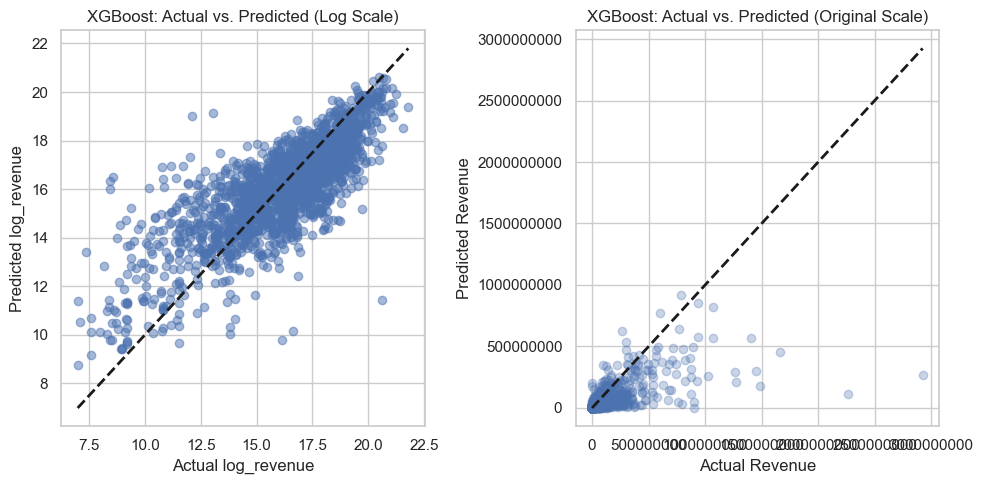

In [39]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_xgb, alpha=0.5) # Using XGBoost predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual log_revenue')
plt.ylabel('Predicted log_revenue')
plt.title('XGBoost: Actual vs. Predicted (Log Scale)')

plt.subplot(1, 2, 2)
y_test_orig = np.expm1(y_test)
y_pred_xgb_orig = np.expm1(y_pred_xgb)
y_pred_xgb_orig = np.maximum(0, y_pred_xgb_orig) # Clip negative predictions

plt.scatter(y_test_orig, y_pred_xgb_orig, alpha=0.3)
# Determine appropriate limits for original scale plot to see detail
# For instance, filter out extreme outliers for visualization if they squash the plot
# plot_max = np.percentile(np.concatenate([y_test_orig, y_pred_xgb_orig]), 99)
# plt.xlim(0, plot_max)
# plt.ylim(0, plot_max)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('XGBoost: Actual vs. Predicted (Original Scale)')
plt.ticklabel_format(style='plain', axis='both') # Avoid scientific notation
plt.tight_layout()
plt.show()

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("\n--- Starting XGBoost Hyperparameter Tuning ---")

# Define the parameter grid to sample from
param_dist_xgb = {
    'n_estimators': randint(100, 600), # Reduced upper limit
    'learning_rate': uniform(0.02, 0.2), # Increased lower limit for learning_rate
    'max_depth': randint(4, 10),         # Reduced upper limit for depth
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight needed in a child
    'subsample': uniform(0.6, 0.4),      # Subsample ratio of the training instance (0.6 to 1.0)
    'colsample_bytree': uniform(0.6, 0.4),# Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 0.5),            # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),          # L1 regularization term on weights
    'reg_lambda': uniform(0, 1)          # L2 regularization term on weights
}

# Make sure your X_train and y_train are the ones with *CORRECTED* genre features
# And scaled numerical/embedding features

xgb_model_tune = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist' # or 'gpu_hist' if GPU is available and configured
)

# RandomizedSearchCV
# n_iter: number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
# cv: number of folds in cross-validation
# scoring: use 'neg_mean_squared_error' as RandomizedSearchCV tries to maximize the score
# verbose: how much information to print
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_tune,
    param_distributions=param_dist_xgb,
    n_iter=25,  # Adjust n_iter based on available time. 50-100 is a good start.
    scoring='neg_mean_squared_error', # We want to minimize MSE, so maximize -MSE
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

print("Fitting RandomizedSearchCV for XGBoost...")
random_search_xgb.fit(X_train, y_train) # Use your FULL X_train, y_train

print("\n--- XGBoost Hyperparameter Tuning Results ---")
print(f"Best parameters found: {random_search_xgb.best_params_}")
print(f"Best cross-validation RMSE (log scale): {np.sqrt(-random_search_xgb.best_score_):.4f}")

# Get the best estimator
best_xgb_model = random_search_xgb.best_estimator_

# Evaluate the best model on the test set
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb_tuned, "XGBoost (Tuned)")

# You can also inspect feature importances from the best_xgb_model
# feature_importances_xgb_tuned = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns)
# print("\n--- Top 20 XGBoost (Tuned) Feature Importances ---")
# print(feature_importances_xgb_tuned.sort_values(ascending=False).head(20))


--- Starting XGBoost Hyperparameter Tuning ---
Fitting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid dea

KeyboardInterrupt: 

In [43]:
import pickle
import os
import pandas as pd # For DataFrame creation for feature importance
import numpy as np # For np.sqrt if re-evaluating (optional)
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # If re-evaluating

print("\n--- Saving Models and Artifacts ---")

# Create models directory if it doesn't exist
MODELS_DIR = 'saved_models_from_notebook' # Using a new directory name to avoid conflicts
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Directory '{MODELS_DIR}' created.")
else:
    print(f"Directory '{MODELS_DIR}' already exists.")

# --- 1. Define Models to Save (from your notebook's environment) ---
# These should be the model objects already trained in your notebook.
# We'll check if they exist before trying to save them.

models_to_save = {}
model_objects_from_notebook = {}

if 'ridge_model' in locals() and ridge_model is not None:
    model_objects_from_notebook['ridge_regression_notebook'] = ridge_model
    print("Found 'ridge_model' in notebook.")
else:
    print("Warning: 'ridge_model' not found or is None in notebook environment.")

if 'rf_model' in locals() and rf_model is not None: # Assuming you named your RF model 'rf_model'
    model_objects_from_notebook['random_forest_notebook_untuned'] = rf_model
    print("Found 'rf_model' (untuned) in notebook.")
else:
    print("Warning: 'rf_model' (untuned) not found or is None in notebook environment.")

if 'best_xgb_model' in locals() and best_xgb_model is not None: # From hyperparameter tuning
    model_objects_from_notebook['xgboost_notebook_tuned'] = best_xgb_model
    print("Found 'best_xgb_model' (tuned) in notebook.")
elif 'xgb_model' in locals() and xgb_model is not None: # Fallback to untuned XGBoost if no tuned version
    model_objects_from_notebook['xgboost_notebook_untuned'] = xgb_model
    print("Found 'xgb_model' (untuned) in notebook. Tuned version preferred if available.")
else:
    print("Warning: Neither 'best_xgb_model' nor 'xgb_model' found or is None in notebook environment.")

if not model_objects_from_notebook:
    print("No models found to save. Please ensure models like 'ridge_model', 'rf_model', 'best_xgb_model' are trained in the notebook.")
else:
    print(f"Models identified for saving: {list(model_objects_from_notebook.keys())}")

# --- 2. Save the Scaler ---
# The scaler was fit on X_train's numerical/embedding columns
if 'scaler' in locals() and scaler is not None:
    scaler_path = os.path.join(MODELS_DIR, "data_scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    print(f"Data scaler saved to {scaler_path}")
    # Also save the columns that were scaled
    if 'cols_to_scale' in locals() and cols_to_scale is not None:
        scaled_columns_path = os.path.join(MODELS_DIR, "scaled_columns_list.json")
        import json
        with open(scaled_columns_path, 'w') as f:
            json.dump(cols_to_scale, f)
        print(f"List of scaled columns saved to {scaled_columns_path}")
    else:
        print("Warning: 'cols_to_scale' list not found. Scaler saved, but column context missing.")
else:
    print("Warning: 'scaler' object not found. Cannot save the scaler. Predictions on new data will be problematic if scaling was used.")

# --- 3. Save the Training Columns ---
# This is crucial for ensuring new data has the same features in the same order.
if 'X_train' in locals() and hasattr(X_train, 'columns'):
    training_columns = X_train.columns.tolist()
    columns_path = os.path.join(MODELS_DIR, "training_columns_list.json")
    import json # ensure imported
    with open(columns_path, 'w') as f:
        json.dump(training_columns, f)
    print(f"Training columns list saved to {columns_path}")
else:
    print("Warning: 'X_train' or its columns not found. Cannot save the training columns list.")
    training_columns = [] # Define for feature importance part to not error out

# --- 4. Save Models and Feature Importances ---
for name, model_instance in model_objects_from_notebook.items():
    print(f"\nProcessing model: {name}...")
    model_path = os.path.join(MODELS_DIR, f"{name}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model_instance, f)
    print(f"  Model saved as {model_path}")

    # Save feature importance if available (for tree-based models)
    if hasattr(model_instance, 'feature_importances_'):
        if training_columns: # Check if we have column names
            try:
                feature_importance = pd.DataFrame({
                    'Feature': training_columns, # Use columns from X_train
                    'Importance': model_instance.feature_importances_
                }).sort_values('Importance', ascending=False)
                
                importance_filename = f"{name}_feature_importance.csv"
                importance_path = os.path.join(MODELS_DIR, importance_filename)
                feature_importance.to_csv(importance_path, index=False)
                print(f"  Feature importance saved to {importance_path}")
            except ValueError as e:
                print(f"  Error creating feature importance for {name}: {e}. Might be a mismatch in length of columns and importances.")
            except Exception as e:
                print(f"  An unexpected error occurred while saving feature importance for {name}: {e}")
        else:
            print(f"  Cannot save feature importance for {name} because training_columns list is unavailable.")
    else:
        print(f"  Model {name} does not have 'feature_importances_' attribute.")


# --- Optional: Save MultiLabelBinarizers if they were stored ---
# This part is more complex as you might have multiple MLB objects.
# For simplicity, this example assumes they might be in a dictionary called 'mlb_objects'
# Example: mlb_objects = {'genres': mlb_genres, 'keywords': mlb_keywords}
if 'mlb_objects' in locals() and isinstance(mlb_objects, dict):
    for mlb_name, mlb_instance in mlb_objects.items():
        if mlb_instance is not None:
            mlb_path = os.path.join(MODELS_DIR, f"mlb_{mlb_name}.pkl")
            with open(mlb_path, "wb") as f:
                pickle.dump(mlb_instance, f)
            print(f"MLB for '{mlb_name}' saved to {mlb_path}")
else:
    print("Note: MultiLabelBinarizer objects ('mlb_objects' dictionary) not found or not a dict. These would be needed for full raw data preprocessing.")

# --- Optional: Save OneHotEncoder if it was stored ---
# if 'ohe_object' in locals() and ohe_object is not None: # Assuming you stored your OHE
#    ohe_path = os.path.join(MODELS_DIR, "one_hot_encoder.pkl")
#    with open(ohe_path, "wb") as f:
#        pickle.dump(ohe_object, f)
#    print(f"OneHotEncoder saved to {ohe_path}")
# else:
#    print("Note: OneHotEncoder object ('ohe_object') not found. This would be needed for full raw data preprocessing.")


print("\n--- Model and artifact saving process complete! ---")
print(f"Artifacts saved in directory: '{MODELS_DIR}'")

# You could add a section here to load one of the saved models and test it
# on X_test again to verify the saving/loading process, but it's optional.


--- Saving Models and Artifacts ---
Directory 'saved_models_from_notebook' created.
Found 'ridge_model' in notebook.
Found 'rf_model' (untuned) in notebook.
Found 'xgb_model' (untuned) in notebook. Tuned version preferred if available.
Models identified for saving: ['ridge_regression_notebook', 'random_forest_notebook_untuned', 'xgboost_notebook_untuned']
Data scaler saved to saved_models_from_notebook/data_scaler.pkl
List of scaled columns saved to saved_models_from_notebook/scaled_columns_list.json
Training columns list saved to saved_models_from_notebook/training_columns_list.json

Processing model: ridge_regression_notebook...
  Model saved as saved_models_from_notebook/ridge_regression_notebook.pkl
  Model ridge_regression_notebook does not have 'feature_importances_' attribute.

Processing model: random_forest_notebook_untuned...
  Model saved as saved_models_from_notebook/random_forest_notebook_untuned.pkl
  Feature importance saved to saved_models_from_notebook/random_forest_n